#Packages Install and Import


In [ ]:
!pip install imbalanced-learn
!pip install --upgrade pandas
!pip install optuna
!pip install xgboost
!pip install python-dotenv

In [ ]:
import subprocess
import sys

# Upgrade bottleneck package to version 1.3.6 or newer
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "bottleneck"])

import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

In [ ]:
# Set the option to display all rows or a large number
pd.set_option('display.max_rows', None)  # None means show all rows

# Set the option to display all columns or a large number
pd.set_option('display.max_columns', None)  # None means show all columns

pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.4f}'.format)

#Load Data and Check Null Values

In [ ]:
# Load Data
dataset = pd.read_csv("zero_div_all_years.csv")
num_dataset = dataset.select_dtypes(include=[np.number])
# Null value analysis
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 179 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    year                                                  4111 non-null   int64  
 1    adjDividend                                           4111 non-null   float64
 2    dps_growth                                            4111 non-null   float64
 3    dps_growth_rate                                       4111 non-null   float64
 4    industry                                              4111 non-null   object 
 5    sector                                                4111 non-null   object 
 6    companyRating                                         4111 non-null   float64
 7    companyRating_percentage_change                       4111 non-null   float64
 8    companyRating_actual_change                   

#Multivariate Analysis

In [ ]:
# Correlation matrix
correlation_matrix = num_dataset.corr()

def rank_columns_by_correlation(df, threshold):
    # Calculating correlation matrix
    corr_matrix = df.corr()
    # Initializing a list to hold the tuples (col1, col2, correlation)
    correlations = []
    # Iterating over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # avoiding duplicate and self-correlation
            # Including only correlations above the specified threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Sorting the list by absolute correlation in descending order
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column1', 'Column2', 'Correlation'])
    return correlation_df

top_correlations = rank_columns_by_correlation(num_dataset, 0.9)

# Remove highly correlated columns
columns_to_remove = top_correlations["Column2"].unique()
dataset.drop(columns_to_remove, axis="columns", inplace=True)

#Train-Test Split

In [ ]:
# Data Separation by Year
training_data = dataset.loc[dataset["year"] < 2021]
testing_data = dataset[(dataset['year'] == 2021) | (dataset['year'] == 2022)]


# Predictor - Target Split
X_train = training_data.drop("dps_change_next_year", axis="columns")
y_train = training_data["dps_change_next_year"]
X_test = testing_data.drop("dps_change_next_year", axis="columns")
y_test = testing_data["dps_change_next_year"]

#Data Pre-Processing, Encode Categorical Features, Normalize Feature Values

In [ ]:
# Define categorical and other columns
categorical_columns = ["industry", "sector", "symbol"]
other_columns = [col for col in X_train.columns if col not in categorical_columns]

# Preprocessing: Label encoding and Scaling
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

# Standard scaling within a pipeline to prevent data leakage
pipeline_preprocess = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler())
])

X_train_transformed = pipeline_preprocess.fit_transform(X_train)
X_test_transformed = pipeline_preprocess.transform(X_test)

# Note: after transformation, the output will be a numpy array and column orders will be changed.
X_train_transformed = pd.DataFrame(X_train_transformed, columns=categorical_columns + other_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=categorical_columns + other_columns)

# Check our data type
X_train_transformed.info(verbose=True, show_counts=True)

# Let's change our data types back to their original forms - However, this time, categorical variables have become
# number like strings
cols_to_convert = {'industry': 'str', 'sector': 'str', 'symbol': 'str', 'year': 'int'}
X_train_transformed = X_train_transformed.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349 entries, 0 to 3348
Data columns (total 117 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    industry                                              3349 non-null   float64
 1    sector                                                3349 non-null   float64
 2    symbol                                                3349 non-null   float64
 3    year                                                  3349 non-null   float64
 4    adjDividend                                           3349 non-null   float64
 5    dps_growth                                            3349 non-null   float64
 6    dps_growth_rate                                       3349 non-null   float64
 7    companyRating                                         3349 non-null   float64
 8    companyRating_percentage_change               

#Check Data Imbalanced

In [ ]:
training_data_transformed = pd.concat([X_train_transformed, y_train], axis=1)
training_data_transformed["dps_change_next_year"].value_counts()

dps_change_next_year
constant/increased    3123
decreased              226
Name: count, dtype: int64

#Stratified Cross-Validation and Smote Oversampling

In [ ]:
# Stratified Cross-Validation Setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform oversampling using SMOTE
categorical_indices = [X_train_transformed.columns.get_loc(col) for col in categorical_columns]
smote = SMOTENC(random_state=1, categorical_features=categorical_indices)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_transformed, y_train)
# Check our training data
pd.DataFrame(y_train_oversampled)["dps_change_next_year"].value_counts()
X_train_oversampled.info()
y_train_oversampled.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6246 entries, 0 to 6245
Columns: 117 entries, industry to enterpriseValueMultiple
dtypes: float64(113), int64(1), object(3)
memory usage: 5.6+ MB


dps_change_next_year
constant/increased    3123
decreased             3123
Name: count, dtype: int64

#Feature Selection

#Feature Engineering(PCA)

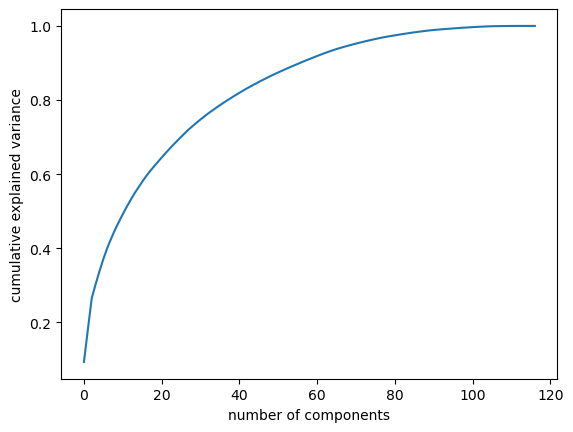

In [ ]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_oversampled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

pca = PCA(n_components = 0.95)

X_train_final = pca.fit_transform(X_train_oversampled)
X_test_final = pca.transform(X_test_transformed)

explained_variance = pca.explained_variance_ratio_


#Model Training

##Logistic Regression

In [ ]:
# Simulate best_params_lr
best_params_lr = {"C": 1.0, "penalty": "l2"}

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)

# Define the directory and file path to save the model
model_dir = 'best_models'
model_file = os.path.join(model_dir, 'lr.pkl')

# If the directory does not exist, create the directory
os.makedirs(model_dir, exist_ok=True)

# Save model
with open(model_file, 'wb') as file:
    pickle.dump(best_model_lr, file)

In [ ]:
# Bayesian Optimization with optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress log messages

# Logistic Regression
def objective_function(trial):
    C = trial.suggest_float('C', 0.1, 10, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver='liblinear',
        n_jobs=-1
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, C: {C}, penalty: {penalty}, ROC-AUC: {roc_auc}")
    return roc_auc


study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_function, n_trials=25)

best_params_lr = study_lr.best_params
print("Best Parameters: ", best_params_lr)
print("Best ROC-AUC Score: ", study_lr.best_value)

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)
with open('best_models/lr.pkl', 'wb') as file:
    pickle.dump(best_model_lr, file)

Trial 1, C: 0.22073258377690094, penalty: l2, ROC-AUC: 0.775346121025641
Trial 2, C: 0.1101402898267277, penalty: l1, ROC-AUC: 0.7710763199999999
Trial 3, C: 0.3100343838225722, penalty: l2, ROC-AUC: 0.775844402871795
Trial 4, C: 3.2652285270939347, penalty: l2, ROC-AUC: 0.7774384697435897
Trial 5, C: 0.3476142473339735, penalty: l1, ROC-AUC: 0.7745392516923078
Trial 6, C: 0.13897751618089835, penalty: l2, ROC-AUC: 0.7745649165128206
Trial 7, C: 4.8960997177072985, penalty: l2, ROC-AUC: 0.7777177903589744
Trial 8, C: 3.598559314354029, penalty: l2, ROC-AUC: 0.7774943269743589
Trial 9, C: 0.23158511180734323, penalty: l2, ROC-AUC: 0.7754122486153847
Trial 10, C: 0.10959568291442946, penalty: l1, ROC-AUC: 0.7710619741538461
Trial 11, C: 9.26099495927853, penalty: l1, ROC-AUC: 0.7778590424615384
Trial 12, C: 9.294731905119324, penalty: l1, ROC-AUC: 0.7780190498461539
Trial 13, C: 9.09658656941231, penalty: l1, ROC-AUC: 0.7780734252307694
Trial 14, C: 1.388425865293794, penalty: l1, ROC-AU

##Decision Tree

In [ ]:
# Decision Tree
def objective_function(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, "
          f"min_samples_leaf: {min_samples_leaf}, criterion: {criterion}, ROC-AUC: {roc_auc}")
    return roc_auc

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_function, n_trials=50)

best_params_dt = study_dt.best_params
print("Best Parameters: ", best_params_dt)
print("Best ROC-AUC Score: ", study_dt.best_value)

# Create and save model
best_model_dt = DecisionTreeClassifier(**best_params_dt)
with open('best_models/dt.pkl', 'wb') as file:
    pickle.dump(best_model_dt, file)



Trial 1, max_depth: 3, min_samples_split: 6, min_samples_leaf: 5, criterion: entropy, ROC-AUC: 0.6832670847179486
Trial 2, max_depth: 31, min_samples_split: 10, min_samples_leaf: 13, criterion: gini, ROC-AUC: 0.8372272213333334
Trial 3, max_depth: 24, min_samples_split: 3, min_samples_leaf: 5, criterion: gini, ROC-AUC: 0.8369680201025641
Trial 4, max_depth: 50, min_samples_split: 13, min_samples_leaf: 12, criterion: gini, ROC-AUC: 0.8382107663589743
Trial 5, max_depth: 27, min_samples_split: 11, min_samples_leaf: 1, criterion: gini, ROC-AUC: 0.8294395856410256
Trial 6, max_depth: 18, min_samples_split: 14, min_samples_leaf: 11, criterion: gini, ROC-AUC: 0.838472733128205
Trial 7, max_depth: 34, min_samples_split: 9, min_samples_leaf: 8, criterion: gini, ROC-AUC: 0.842554774153846
Trial 8, max_depth: 42, min_samples_split: 10, min_samples_leaf: 10, criterion: gini, ROC-AUC: 0.8375609411282051
Trial 9, max_depth: 16, min_samples_split: 8, min_samples_leaf: 12, criterion: gini, ROC-AUC: 0

##KNN

In [ ]:
# KNN
def objective_function(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        metric=metric
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, n_neighbors: {n_neighbors}, weights: {weights}, p: {p}, metric: {metric}, "
          f"ROC-AUC: {roc_auc}")
    return roc_auc


study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_function, n_trials=50)

best_params_knn = study_knn.best_params
print("Best Parameters: ", best_params_knn)
print("Best ROC-AUC Score: ", study_knn.best_value)

# Create and save model
best_model_knn = KNeighborsClassifier(**best_params_knn)
with open('best_models/knn.pkl', 'wb') as file:
    pickle.dump(best_model_knn, file)

Trial 1, n_neighbors: 13, weights: uniform, p: 4, metric: manhattan, ROC-AUC: 0.9498150248205128
Trial 2, n_neighbors: 20, weights: distance, p: 2, metric: manhattan, ROC-AUC: 0.9510600233846154
Trial 3, n_neighbors: 16, weights: distance, p: 4, metric: minkowski, ROC-AUC: 0.9287997054358975
Trial 4, n_neighbors: 4, weights: uniform, p: 2, metric: manhattan, ROC-AUC: 0.9462457595897437
Trial 5, n_neighbors: 12, weights: distance, p: 4, metric: euclidean, ROC-AUC: 0.953284982974359
Trial 6, n_neighbors: 23, weights: uniform, p: 4, metric: euclidean, ROC-AUC: 0.9092122572307693
Trial 7, n_neighbors: 5, weights: distance, p: 3, metric: manhattan, ROC-AUC: 0.954933104820513
Trial 8, n_neighbors: 5, weights: distance, p: 5, metric: euclidean, ROC-AUC: 0.9452654391794872
Trial 9, n_neighbors: 4, weights: distance, p: 5, metric: manhattan, ROC-AUC: 0.9485568102564101
Trial 10, n_neighbors: 28, weights: distance, p: 2, metric: euclidean, ROC-AUC: 0.9271295368205127
Trial 11, n_neighbors: 9, we

##Random Forest

In [ ]:
# Random Forest
def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
          f"min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, ROC-AUC: {roc_auc}")
    return roc_auc


study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_function, n_trials=50)

best_params_rf = study_rf.best_params
print("Best Parameters: ", best_params_rf)
print("Best ROC-AUC: Score: ", study_rf.best_value)

# Create and save model
best_model_rf = RandomForestClassifier(**best_params_rf, n_jobs=-1)
with open('best_models/rf.pkl', 'wb') as file:
    pickle.dump(best_model_rf, file)


Trial 1, n_estimators: 124, max_depth: 36, min_samples_split: 12, min_samples_leaf: 1, ROC-AUC: 0.9681772767179486
Trial 2, n_estimators: 82, max_depth: 49, min_samples_split: 4, min_samples_leaf: 10, ROC-AUC: 0.946188544
Trial 3, n_estimators: 118, max_depth: 47, min_samples_split: 8, min_samples_leaf: 12, ROC-AUC: 0.9402963011282051
Trial 4, n_estimators: 107, max_depth: 28, min_samples_split: 15, min_samples_leaf: 10, ROC-AUC: 0.9466330412307691
Trial 5, n_estimators: 11, max_depth: 35, min_samples_split: 11, min_samples_leaf: 3, ROC-AUC: 0.9407420713846154
Trial 6, n_estimators: 64, max_depth: 34, min_samples_split: 12, min_samples_leaf: 10, ROC-AUC: 0.9448833805128205
Trial 7, n_estimators: 80, max_depth: 36, min_samples_split: 6, min_samples_leaf: 6, ROC-AUC: 0.9582893284102564
Trial 8, n_estimators: 144, max_depth: 6, min_samples_split: 3, min_samples_leaf: 12, ROC-AUC: 0.8660129115897435
Trial 9, n_estimators: 88, max_depth: 20, min_samples_split: 12, min_samples_leaf: 8, ROC-A

##XgBoost

In [ ]:
# XgBoost
# It requires the target to be 0 and 1, and all features be numerical
# Encode our target
label_encoder = LabelEncoder()
# Fit the encoder and transform the target variable
y_train_oversampled_encoded = label_encoder.fit_transform(y_train_oversampled)


# This suppresses printing logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.9, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled_encoded, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate},"
          f"min_child_weight: {min_child_weight}, subsample: {subsample}, colsample_bytree: {colsample_bytree}, "
          f"gamma: {gamma}, reg_alpha: {reg_alpha}, reg_lambda: {reg_lambda}, ROC-AUC: {roc_auc}")
    return roc_auc


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_function, n_trials=50)

best_params_xgb = study_xgb.best_params
print("Best Parameters: ", best_params_xgb)
print("Best ROC-AUC Score: ", study_xgb.best_value)

best_model_xgb = XGBClassifier(**best_params_xgb, use_label_encoder=False, n_jobs=-1)
with open('best_models/xgb.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)


Trial 1, n_estimators: 110, max_depth: 34, learning_rate: 0.001958840495854397,min_child_weight: 5, subsample: 0.7695482912462832, colsample_bytree: 0.8074540540997439, gamma: 0.7901636325102008, reg_alpha: 0.39836403259268216, reg_lambda: 0.12963181499991316, ROC-AUC: 0.932913664
Trial 2, n_estimators: 129, max_depth: 1, learning_rate: 0.8338028553602168,min_child_weight: 6, subsample: 0.6590168721814942, colsample_bytree: 0.8377813113386483, gamma: 0.36272687086496813, reg_alpha: 0.3416606633538214, reg_lambda: 0.04059438148794681, ROC-AUC: 0.8435899454358975
Trial 3, n_estimators: 23, max_depth: 40, learning_rate: 0.06529050073731792,min_child_weight: 2, subsample: 0.513712275604521, colsample_bytree: 0.7390016254268915, gamma: 0.5678588455944734, reg_alpha: 0.5066285022063601, reg_lambda: 0.33141854693853456, ROC-AUC: 0.9429796151794871
Trial 4, n_estimators: 72, max_depth: 11, learning_rate: 0.02039029248876044,min_child_weight: 9, subsample: 0.8836499508282909, colsample_bytree: 

Trial 30, n_estimators: 14, max_depth: 33, learning_rate: 0.19854236292762956,min_child_weight: 6, subsample: 0.8087943218466193, colsample_bytree: 0.8316261123919271, gamma: 0.40113039678650153, reg_alpha: 0.3946875421251171, reg_lambda: 0.8854052402322532, ROC-AUC: 0.9409225222564104
Trial 31, n_estimators: 53, max_depth: 34, learning_rate: 0.08266635282078302,min_child_weight: 5, subsample: 0.7152313698766495, colsample_bytree: 0.6372942806677658, gamma: 0.5100433554409352, reg_alpha: 0.3476978944385233, reg_lambda: 0.6865053451608822, ROC-AUC: 0.9642823909743591
Trial 32, n_estimators: 66, max_depth: 21, learning_rate: 0.1547391700817909,min_child_weight: 4, subsample: 0.9511735475404264, colsample_bytree: 0.599161536665171, gamma: 0.7328022890803837, reg_alpha: 0.12709830345926543, reg_lambda: 0.9902422599417696, ROC-AUC: 0.972619104
Trial 33, n_estimators: 68, max_depth: 19, learning_rate: 0.04769818647208472,min_child_weight: 4, subsample: 0.9921809725280794, colsample_bytree: 0

#Model Selection

In [ ]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Evaluates multiple models by fitting them on training data, predicting probabilities on test data,
    comparing predicted results with actual results, and computing the ROC AUC score for each.

    Parameters:
    - models: dict, a dictionary of models where keys are model names and values are the model instances.
    - X_train: array-like, training features.
    - y_train: array-like, training target.
    - X_test: array-like, testing features.
    - y_test: array-like, testing target.

    Returns:
    - result_df: DataFrame, a DataFrame containing actual values, predicted probabilities and model comparisons.
    """
    predictions = {'Actual': y_test}
    performances = {}
    print("Testing Performances...Please wait")

    for model_name, model in models.items():
      if model_name == 'XGBoost':
        # Fit and transform the labels in the training data
        y_train = label_encoder.fit_transform(y_train)

        # Transform the labels in the test data
        y_test = label_encoder.transform(y_test)
      else:
        # Fit the model
        model.fit(X_train, y_train)

        # Predict probabilities
        predicted_probs = model.predict_proba(X_test)[:, 1]
        predictions[f'Predicted_Prob_{model_name}'] = predicted_probs

        # Compute ROC AUC score
        roc_auc = roc_auc_score(y_test, predicted_probs)
        performances[model_name] = roc_auc
        print(f"{model_name} ROC AUC: {roc_auc:.4f}")

    # Create a DataFrame from the predictions dictionary
    result_df = pd.DataFrame(predictions)

    # Add a summary of performances at the end of the DataFrame
    performance_summary = pd.DataFrame([performances], index=['ROC AUC Score'])

    return result_df, performance_summary

# Example usage:
models = {
    'Logistic Regression': best_model_lr,
    'Decision Tree': best_model_dt,
    'KNN': best_model_knn,
    'Random Forest': best_model_rf,
    'XGBoost': best_model_xgb
}

# Assuming X_train_final, y_train_oversampled, X_test_final, y_test are already defined and prepared
prediction_results, performance_summary = evaluate_models(models, X_train_final, y_train_oversampled, X_test_final, y_test)



Testing Performances...Please wait
Logistic Regression ROC AUC: 0.9527
Decision Tree ROC AUC: 0.2762
KNN ROC AUC: 0.5756
Random Forest ROC AUC: 0.5936


In [ ]:
prediction_results.to_csv('prediction.csv', index=False)

prediction_results

,Actual,Predicted_Prob_Logistic Regression,Predicted_Prob_Decision Tree,Predicted_Prob_KNN,Predicted_Prob_Random Forest
9,constant/increased,0.0056,0.5000,0.2500,0.2547
10,decreased,0.9603,0.0000,0.8750,0.4019
20,constant/increased,0.0018,0.5000,0.5000,0.2586
21,decreased,0.8039,0.0000,0.7500,0.2606
31,constant/increased,0.0014,0.5000,0.3750,0.2749
32,decreased,0.8066,1.0000,0.2500,0.1891
42,constant/increased,0.0027,0.5000,0.0000,0.2439
43,decreased,0.8024,0.5000,0.0000,0.2541
53,constant/increased,0.0006,0.2500,0.0000,0.2150
54,decreased,0.4573,0.0000,0.1250,0.2339


In [ ]:
# Define the path to save the file on the desktop
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')

# Save the filtered data back to a CSV file on the desktop
prediction_results.to_csv(os.path.join(desktop_path, 'filtered_Stock_data_new.csv'), index=False)

print("Filtered CSV file has been saved to your desktop.")

Filtered CSV file has been saved to your desktop.
